In [1]:
from collections import defaultdict
import pandas as pd

prices = []
trades = []

for day in range(-2, 1):
    prices.append(pd.read_csv(f'../../data/prices_round_1_day_{day}.csv', sep=';'))
    trades.append(pd.read_csv(f'../../data/trades_round_1_day_{day}_nn.csv', sep=';'))

prices = pd.concat(prices, axis=0, ignore_index=True)
trades = pd.concat(trades, axis=0, ignore_index=True)

In [2]:
prices.head()

,day,timestamp,product,bid_price_1,bid_volume_1,bid_price_2,bid_volume_2,bid_price_3,bid_volume_3,ask_price_1,ask_volume_1,ask_price_2,ask_volume_2,ask_price_3,ask_volume_3,mid_price,profit_and_loss
0,-2,0,AMETHYSTS,9996,1,9995.0,25.0,NaN,NaN,10004,1,10005.0,25.0,NaN,NaN,10000.0,0.0
1,-2,0,STARFRUIT,4997,26,NaN,NaN,NaN,NaN,5003,26,NaN,NaN,NaN,NaN,5000.0,0.0
2,-2,100,AMETHYSTS,10000,5,9995.0,20.0,NaN,NaN,10005,20,NaN,NaN,NaN,NaN,10002.5,0.0
3,-2,100,STARFRUIT,5000,5,4998.0,6.0,4997.0,20.0,5004,20,NaN,NaN,NaN,NaN,5002.0,0.0
4,-2,200,STARFRUIT,4997,1,4996.0,30.0,NaN,NaN,5003,31,NaN,NaN,NaN,NaN,5000.0,0.0


In [3]:
trades.head()

,timestamp,buyer,seller,symbol,currency,price,quantity
0,0,NaN,NaN,AMETHYSTS,SEASHELLS,9996.0,1
1,0,NaN,NaN,STARFRUIT,SEASHELLS,5003.0,1
2,0,NaN,NaN,AMETHYSTS,SEASHELLS,9996.0,1
3,100,NaN,NaN,STARFRUIT,SEASHELLS,5004.0,6
4,900,NaN,NaN,STARFRUIT,SEASHELLS,5001.0,2


In [4]:
spread_dist = defaultdict(lambda: defaultdict(int))

for price in prices.iterrows():
    for trade in trades[(trades['timestamp'] == price[1]['timestamp']) & (trades['symbol'] == price[1]['product'])].iterrows():
        spread_dist[price[1]['product']][abs(trade[1]['price'] - (price[1]['ask_price_1'] + price[1]['bid_price_1']) / 2)] += trade[1]['quantity']

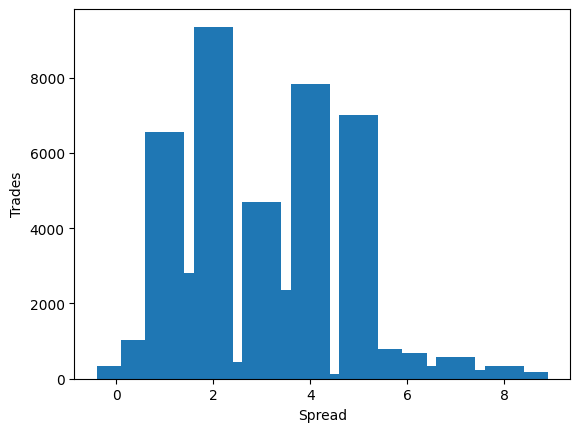

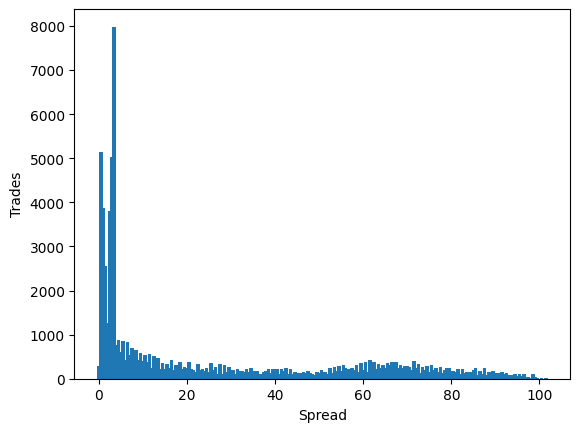

In [5]:
import matplotlib.pyplot as plt

def plot_histogram(dictionary):
    # Sort the dictionary by keys
    sorted_dict = sorted(dictionary.items())

    # Extract keys and values
    keys = [item[0] for item in sorted_dict]
    values = [item[1] for item in sorted_dict]

    # Plot histogram
    plt.bar(keys, values)
    plt.xlabel('Spread')
    plt.ylabel('Trades')
    plt.show()

plot_histogram(spread_dist['AMETHYSTS'])
plot_histogram(spread_dist['STARFRUIT'])